In [84]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array,array_to_img
from tensorflow.keras.applications.resnet import preprocess_input,decode_predictions
import matplotlib.cm as cm
from IPython.display import Image, display

W tym ćwiczeniu skorzystam z przygotowanej wczesniej sieci ResNet wytrenowanej na zbiorze ImageNet. ImageNet jest to zbiór składający się z tysięcy obrazków podzielonych na klasy, które grupują przedmioty codziennego użytku. ResNet jest to sieć konwolucyjna składająca się z 50 warstw wytrenowana na tym zbiorze. W tym cwiczeniu wykorzystam ją, aby sprawdzić jak możemy wytłumaczyć jej predykcje na różnego rodzaju obrazkach zwierząt.

In [ ]:
model = ResNet50()
def prep(path,displ=True):
    im = load_img(path,target_size= (224,224))
    if displ:
        display(im)
    im = img_to_array(im)
    im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
    im = preprocess_input(im)
    pred = model.predict(im)
    lab = decode_predictions(pred)
    labs = []
    for i in range(len(lab[0])):
        labs.append({lab[0][i][1]:lab[0][i][2]})
    print(labs)
    return None

#paths
rabbit = 'rabbit.jpg'
hare = 'hare.jpg'
plush_rabbit = 'plush_rabbit.jpg'
plush_hare = 'plush_hare.jpeg'

animals = [rabbit,hare,plush_rabbit,plush_hare]

Bedę pracował na 4 zdjęciach. Przedstawiają one królika, zająca oraz pluszowe odpowiedniki tych dwóch zwierząt. Skorzystam po kolei z analizy Grad Cam oraz Lime, aby się dowiedzieć jakie cechy zdecydowały o tym że sieć zadecydowała że dany obrazek należy do danej klasy.

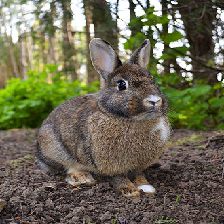

[{'wood_rabbit': 0.60129875}, {'hare': 0.37694508}, {'Angora': 0.0050195297}, {'wallaby': 0.0041386583}, {'fox_squirrel': 0.0022633632}]


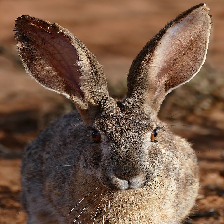

[{'hare': 0.96137685}, {'wood_rabbit': 0.038552087}, {'Angora': 5.3893593e-05}, {'wallaby': 1.6916212e-05}, {'llama': 6.3009935e-08}]


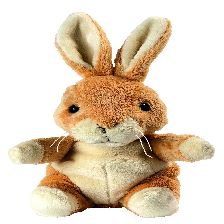

[{'hare': 0.3160408}, {'teddy': 0.3031825}, {'wood_rabbit': 0.040369686}, {'cowboy_hat': 0.037654065}, {'starfish': 0.025654834}]


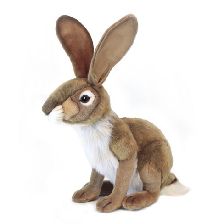

[{'hare': 0.7835436}, {'wood_rabbit': 0.16501932}, {'Angora': 0.0037925842}, {'electric_fan': 0.0026745282}, {'Cardigan': 0.0022578035}]


In [102]:
for animal in animals:
    prep(animal)

# Grad - Cam

In [131]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_3_conv', pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


Źródło: https://keras.io/examples/vision/grad_cam/

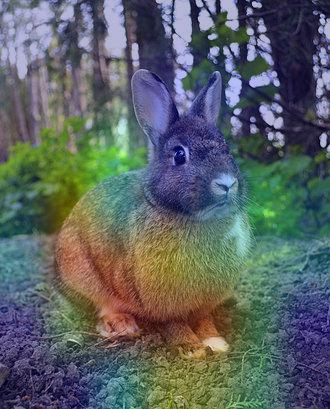

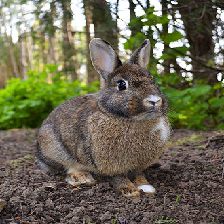

[{'wood_rabbit': 0.60129875}, {'hare': 0.37694508}, {'Angora': 0.0050195297}, {'wallaby': 0.0041386583}, {'fox_squirrel': 0.0022633632}]


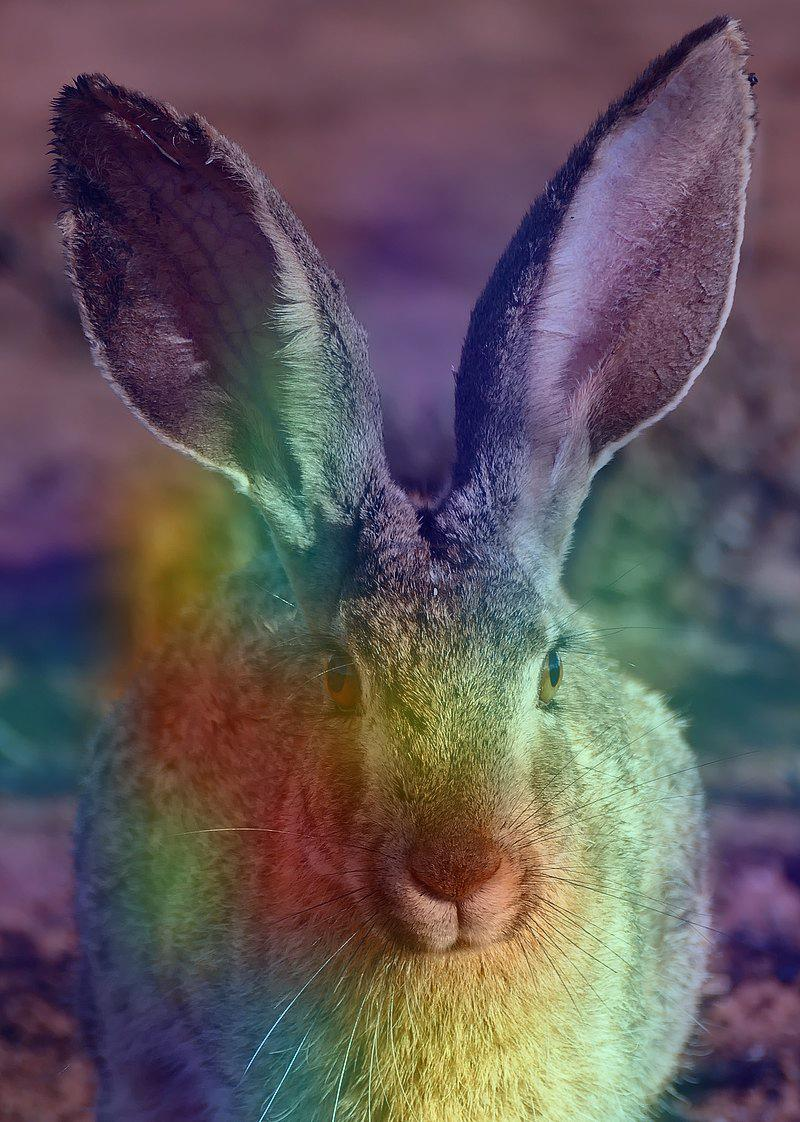

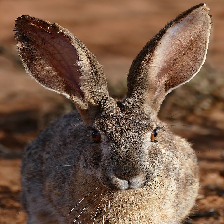

[{'hare': 0.96137685}, {'wood_rabbit': 0.038552087}, {'Angora': 5.3893593e-05}, {'wallaby': 1.6916212e-05}, {'llama': 6.3009935e-08}]


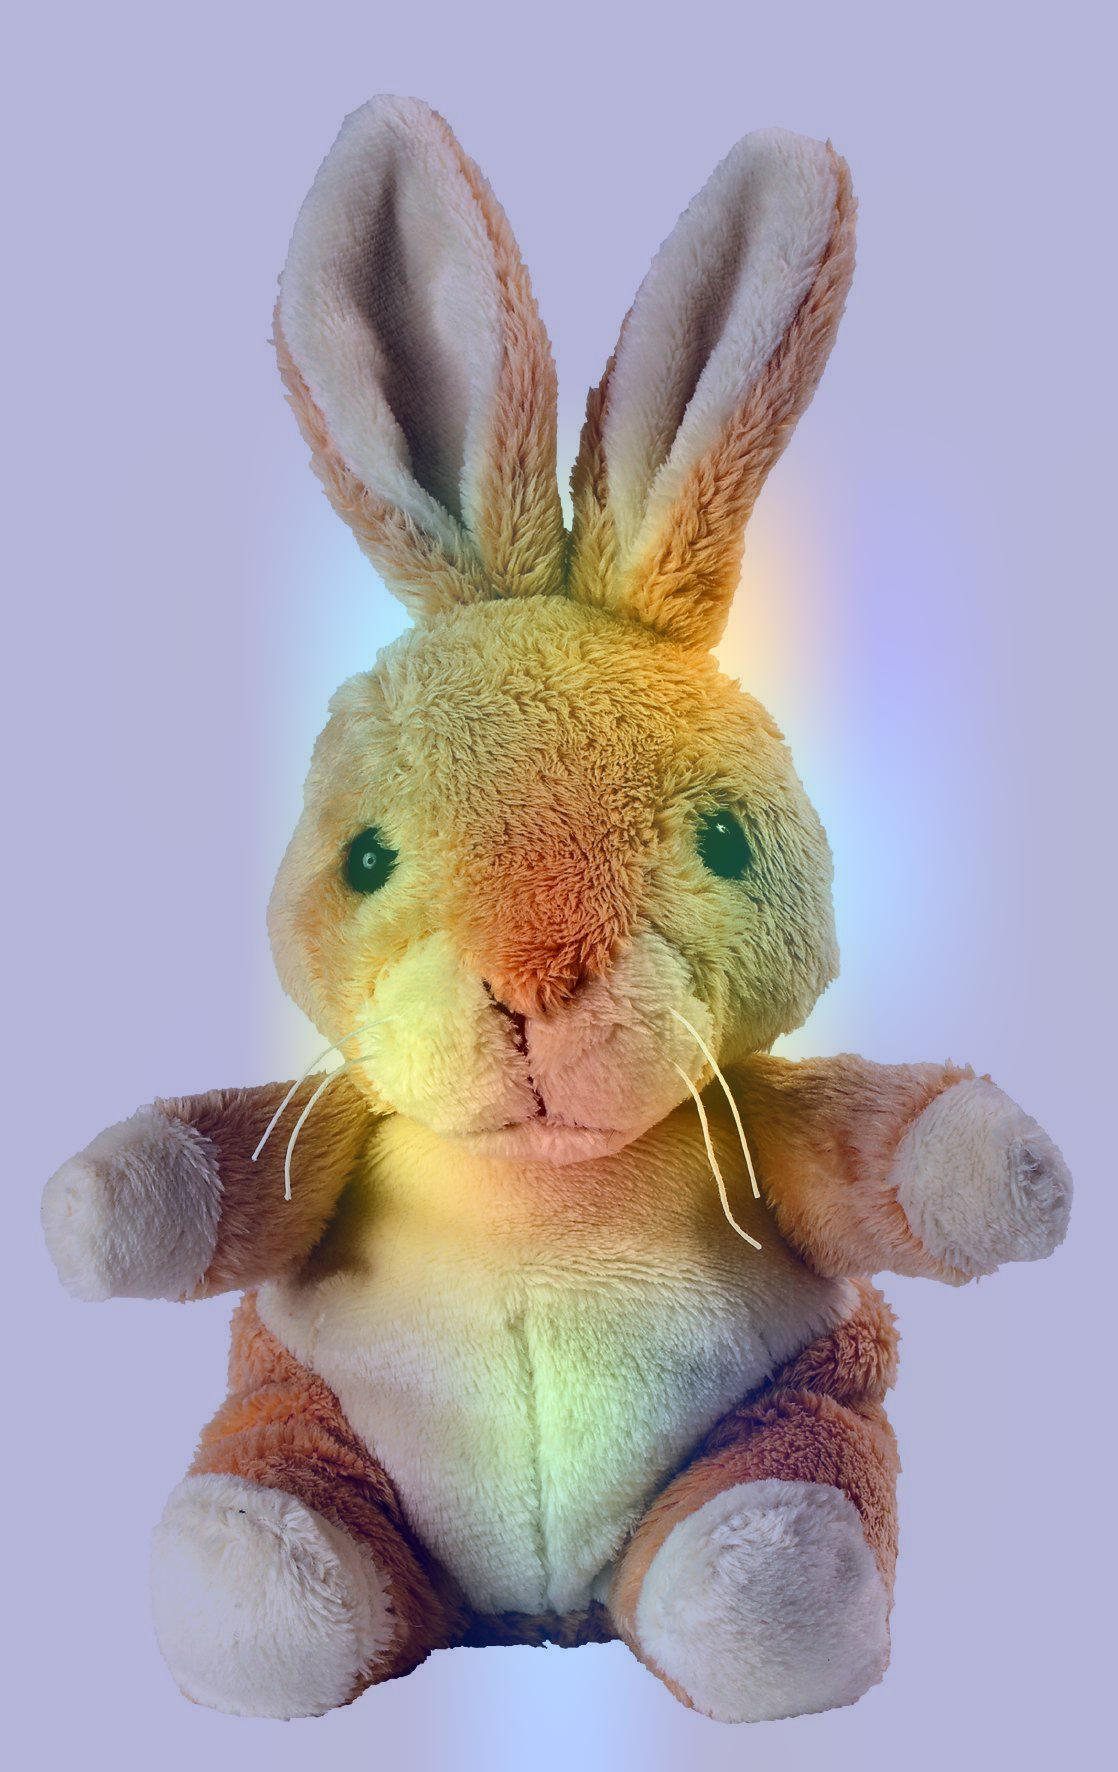

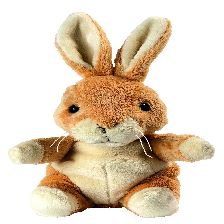

[{'hare': 0.3160408}, {'teddy': 0.3031825}, {'wood_rabbit': 0.040369686}, {'cowboy_hat': 0.037654065}, {'starfish': 0.025654834}]


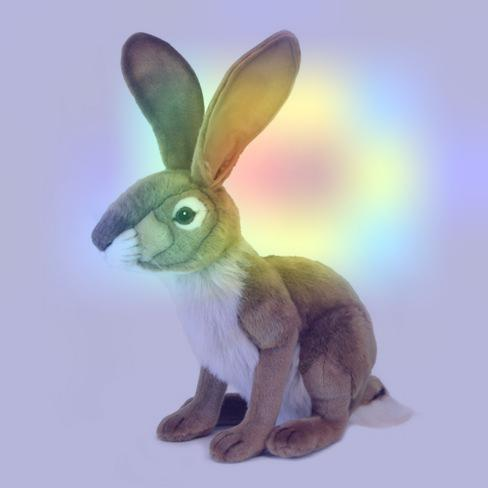

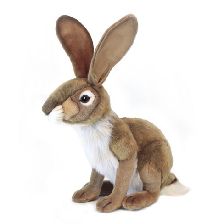

[{'hare': 0.7835436}, {'wood_rabbit': 0.16501932}, {'Angora': 0.0037925842}, {'electric_fan': 0.0026745282}, {'Cardigan': 0.0022578035}]


In [103]:
for animal in animals:
    heatmap = make_gradcam_heatmap(img_array, model)
    img_array = preprocess_input(get_img_array(animal, size=(224,224)))
    save_and_display_gradcam(animal, heatmap)
    prep(animal)

Jak widzimy predykcje zostały wykonane dobrze dla prawdziwych zwierząt. Główne zadanie rozpoznania prawdziwego zająca od królika poszło sieci bardzo dobrze. Co zaskakujące w przypadku tych zwierząt uwaga sieci nie była skupiona na uszach, które dla ludzi są najbardziej rozróżniającym elementem tych zwierząt, a na pyszczku oraz tułowiu tych zwierząt. W przypadku pluszaków sieci nie poszło tak dobrze. W przypadku pluszowego królika sieć uznała go za prawdziwego zająca, a na drugim miejscu jako pluszowego misia. Śmiem twierdzić, iż tego typu przypisanie świadczy o braku klasy pluszowego zająca wśrod klas modelu, jednakże należy podkreślić złą predykcję typu zwierzęcia w tym przypadku. Sieć podobnie jak w przypadku prawdziwych zwierząt największą uwagę zwraca na pyszczek. Pluszowy zając został rozpoznany jako zając, ale w tym wypadku klasa pluszowego misia nie pojawia się nigdzie wysoko, co świadczy o tym, iż sieć uważa pluszaka za prawdziwego.

# Lime

In [120]:
for animal,i in  enumerate(animals):
    print(i)

rabbit.jpg
hare.jpg
plush_rabbit.jpg
plush_hare.jpeg


In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [124]:
def lim(animal):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_to_array(load_img(animal, target_size=(224, 224))).astype('double'),model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
    plt.imshow(np.clip(mark_boundaries(temp / 2 + 0.5, mask), 0, 1))
    prep(animal,displ=False)


[{'wood_rabbit': 0.60129875}, {'hare': 0.37694508}, {'Angora': 0.0050195297}, {'wallaby': 0.0041386583}, {'fox_squirrel': 0.0022633632}]


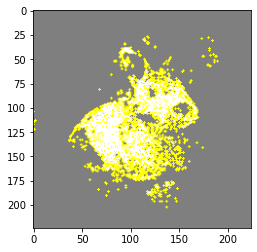

In [126]:
lim(rabbit)


[{'hare': 0.96137685}, {'wood_rabbit': 0.038552087}, {'Angora': 5.3893593e-05}, {'wallaby': 1.6916212e-05}, {'llama': 6.3009935e-08}]


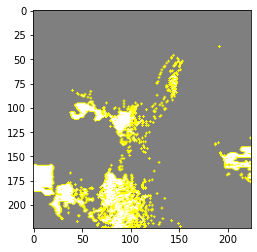

In [127]:
lim(hare)


[{'hare': 0.3160408}, {'teddy': 0.3031825}, {'wood_rabbit': 0.040369686}, {'cowboy_hat': 0.037654065}, {'starfish': 0.025654834}]


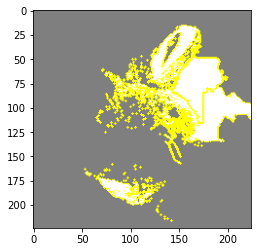

In [129]:
lim(plush_rabbit)


[{'hare': 0.7835436}, {'wood_rabbit': 0.16501932}, {'Angora': 0.0037925842}, {'electric_fan': 0.0026745282}, {'Cardigan': 0.0022578035}]


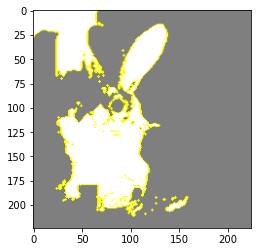

In [130]:
lim(plush_hare)

Rysunki wygenerowane przez lime nie dają aż tak dużo wglądu w to co widzą modele jak grad cam. Jednakże są widoczne różnice, zwłaszcza dla uszu zajęcy. Dla niektórych obrazków lime wskazał cały obszar zwierzęcia jako ten który liczył się w analizie co jest średnio przydatne w kontekscie analizy, jakie elementy wpłynęły na daną klasyfikacje.

# Podsumowanie

Podsumowując moje wyniki uważam iż oba modele wyjasniania uczenia maszynowego spisały się dobrze. Grad Cam sprawia wrażenie tego, który może bardziej pomoć w analizie tego co zadecydowało o danej klasyfikacji. Sieć miała drobne problemy z odpowiednią klasyfikacją poszczególnych zwierząt, jednakże predykcje mają sens, biorąc pod uwagę fakt, iż ta klasyfikacja jest cieżka nawet dla ludzi. Lime zwrócił uwagę na inne aspekty niż Grad Cam, jednakże podświetlenie całego obiektu na zdjęciu nie pomaga w analizie.